In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from statistics import mean, median
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import random
from scipy import stats
import scipy.stats
from scipy.stats import mannwhitneyu

In [ ]:
data=pd.read_csv('post_abtest_data.csv')
data.head()

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
0,867689,2020-05-28,1,Control,1,1,no surge,Android,0.0,1.0,Control
1,867689,2020-05-29,1,Control,1,0,surge,iOS,NaN,NaN,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
4,752172,2020-05-28,1,Control,1,1,no surge,iOS,0.0,0.0,Control


#### **Hypothesis:** When specifying whether the user is sure that the order is canceled outside the center, add a cat emoji asking not to cancel

#### Expected: below cancellation on orders NOT from the center

In [ ]:
data.shape

(101500, 11)

In [ ]:
data1=data[data['city_center_order']==0]

In [ ]:
data1.shape

(39499, 11)

In [ ]:
#calculate conversion to_cancelled
a1=data1[['user_id','order_made', 'user_cancelled']].groupby('user_id').sum()
a1['conversion']=a1['user_cancelled']/a1['order_made']
a1=a1.rename_axis('user_id').reset_index()
a1
data2=data1.merge(a1[['user_id','conversion']], on='user_id',how='left')
data2

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups,conversion
0,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control,0.0
1,752172,2020-05-28,1,Control,1,1,no surge,iOS,0.0,0.0,Control,0.0
2,486559,2020-05-31,1,Control,1,1,no surge,iOS,0.0,0.0,Control,0.0
3,486559,2020-05-30,1,Control,1,1,no surge,Android,0.0,0.0,Control,0.0
4,486559,2020-05-29,1,Control,1,1,no surge,Android,0.0,0.0,Control,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39494,403957,2020-05-31,1,Test,1,1,surge,Android,1.0,0.0,Test,1.0
39495,777242,2020-05-30,1,Test,1,1,no surge,iOS,0.0,0.0,Test,0.0
39496,155474,2020-05-25,1,Test,1,1,no surge,Android,0.0,0.0,Test,0.0
39497,946650,2020-05-26,1,Test,1,1,surge,Android,0.0,0.0,Test,0.0


In [ ]:
data1['date']=data1['date'].astype(str)
data1['date'] = data1['date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
data1['date'] = pd.to_datetime(data1['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

### New loop for periodic p-value

In [ ]:
#calculate periodical p-value for users from control and test gropus
ttest=[]
control_metrics=[]
test_metrics=[]
for data in data1['date'].sort_values(ascending=True).unique():
  data2=data1[data1['date']==data]
  a1=data2.groupby('user_id').agg({'group':'unique','order_made':'sum', 'user_cancelled': 'sum'})

  a1['conversion']=a1['user_cancelled']/a1['order_made']
  a1['group']=[i[0] for i in a1['group']]
  a1=a1.rename_axis('user_id').reset_index()
  
  control=a1[a1['group']=='Control']['conversion'].to_list()
  control_metrics.append(mean(control))
  test=a1[a1['group']=='Test']['conversion'].to_list()
  test_metrics.append(mean(test))
  ttest.append(stats.ttest_ind(control, test)[1])
  print(ttest)

[0.36848311114829835]
[0.36848311114829835, 0.6111710891532758]
[0.36848311114829835, 0.6111710891532758, 0.09157547666074262]
[0.36848311114829835, 0.6111710891532758, 0.09157547666074262, 0.3764575232197056]
[0.36848311114829835, 0.6111710891532758, 0.09157547666074262, 0.3764575232197056, 0.13260853142032983]
[0.36848311114829835, 0.6111710891532758, 0.09157547666074262, 0.3764575232197056, 0.13260853142032983, 0.25315398202393957]
[0.36848311114829835, 0.6111710891532758, 0.09157547666074262, 0.3764575232197056, 0.13260853142032983, 0.25315398202393957, 0.6263643281654507]


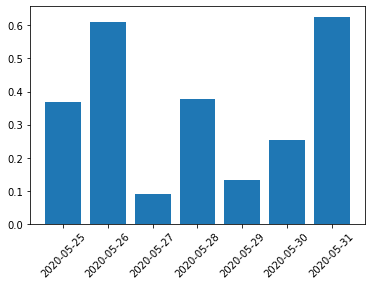

In [ ]:
#visualize received p-value
dates=data1['date'].sort_values(ascending=True).unique()
plt.bar(dates, ttest)
plt.xticks(rotation=45)
plt.show()

**Other values turned out...**

**P-value Conclusion:** P-value is below 0.05 for 5 days out of 7. Two days (June 26 and 31) p-value is above 0.05. But it does not exceed even 0.07 these days, so we can conclude that the difference in the means for the control and test groups is statistically significant.

### Old loop for periodic p-value

In [ ]:
#calculate periodic p-value for users from control and test groups
ttest=[]
control_metrics=[]
test_metrics=[]
for data in data1['date'].sort_values(ascending=True).unique():
  data2=data1[data1['date']==data]

  a1=data2[['user_id','order_made', 'user_cancelled']].groupby('user_id').sum()
  a1['conversion']=a1['user_cancelled']/a1['order_made']
  a1=a1.rename_axis('user_id').reset_index()
  data3=data2.merge(a1[['user_id','conversion']], on='user_id',how='left')
  control=data3[data3['group']=='Control']['conversion'].to_list()
  control_metrics.append(mean(control))
  test=data3[data3['group']=='Test']['conversion'].to_list()
  test_metrics.append(mean(test))
  ttest.append(stats.ttest_ind(control, test)[1])

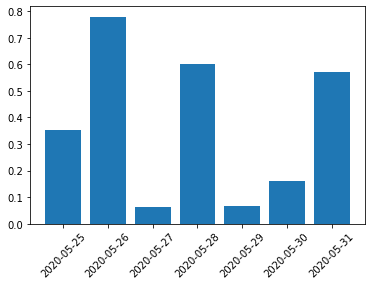

In [ ]:
#visualize received p-value
dates=data1['date'].sort_values(ascending=True).unique()
plt.bar(dates, ttest)
plt.xticks(rotation=45)
plt.show()

### Let's forget about the old loop and look at the difference in to_cancelled conversions for test and control groups:




[numpy.datetime64('2020-05-25T00:00:00.000000000'), numpy.datetime64('2020-05-26T00:00:00.000000000'), numpy.datetime64('2020-05-27T00:00:00.000000000'), numpy.datetime64('2020-05-28T00:00:00.000000000'), numpy.datetime64('2020-05-29T00:00:00.000000000'), numpy.datetime64('2020-05-30T00:00:00.000000000'), numpy.datetime64('2020-05-31T00:00:00.000000000')]


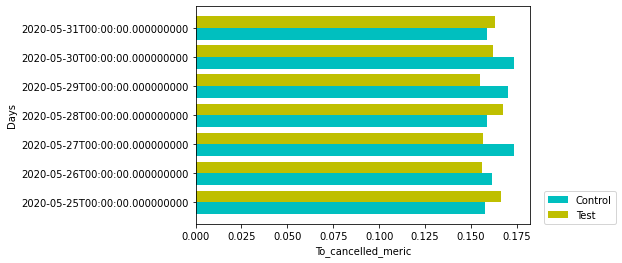

In [ ]:
#difference in conversion for test and control groups

dates=list(data1['date'].sort_values(ascending=True).unique())
print(dates)
X_axis = np.arange(len(dates))
  
plt.barh(X_axis - 0.2, control_metrics, 0.4, label = 'Control', color='c')
plt.barh(X_axis + 0.2, test_metrics, 0.4, label = 'Test', color='y')
  
plt.yticks(X_axis, dates)
#plt.xticks(rotation=45)
plt.ylabel("Days")
plt.xlabel("To_cancelled_meric")
plt.legend(loc=(1.04,0))
plt.show()


**Contradiction:** it turns out that in the data, the conversion to trip cancellation is higher either for the test group or for the control group. Which is very strange and obviously cannot confirm our hypothesis. Even though the p-value shows the stat significance of the difference, we can see that there are both positive and negative effects of the new feature.

**Look at the total p-value for the whole week of the test.**

In [ ]:
#common conversion for test and control group
a1=data1[['user_id','order_made', 'user_cancelled']].groupby('user_id').sum()
a1['conversion']=a1['user_cancelled']/a1['order_made']
a1=a1.rename_axis('user_id').reset_index()
data2=data1.merge(a1[['user_id','conversion']], on='user_id',how='left')
data2=data2.drop_duplicates('user_id')
controll=data2[data2['group']=='Control']['conversion']
testt=data2[data2['group']=='Test']['conversion']

In [ ]:
stats.ttest_ind(controll, testt)

Ttest_indResult(statistic=1.4967989600215057, pvalue=0.13446170055046427)

Which was what was required to be proved...if, of course, I did everything right...the total p-value > 0.05, then our difference is not statistically significant.

Just in case and for the sake of interest, let's calculate the **cumulative p-value**

In [ ]:
#calculate cumulative p-value for users from control and test groups
ttest=[]
control_metrics=[]
test_metrics=[]
data2=data1[data1['date']==data1['date'].sort_values(ascending=True).unique()[0]]
a1=data2.groupby('user_id').agg({'group':'unique','order_made':'sum', 'user_cancelled': 'sum'})
a1['conversion']=a1['user_cancelled']/a1['order_made']
a1['group']=[i[0] for i in a1['group']]
a1=a1.rename_axis('user_id').reset_index()
  
control=a1[a1['group']=='Control']['conversion'].to_list()
control_metrics.append(mean(control))
test=a1[a1['group']=='Test']['conversion'].to_list()
test_metrics.append(mean(test))
ttest.append(stats.ttest_ind(control, test)[1])

for data in data1['date'].sort_values(ascending=True).unique()[1:]:
  data2=pd.concat([data2,data1[data1['date']==data]])
  a1=data2.groupby('user_id').agg({'group':'unique','order_made':'sum', 'user_cancelled': 'sum'})

  a1['conversion']=a1['user_cancelled']/a1['order_made']
  a1['group']=[i[0] for i in a1['group']]
  a1=a1.rename_axis('user_id').reset_index()
  
  control=a1[a1['group']=='Control']['conversion'].to_list()
  control_metrics.append(mean(control))
  test=a1[a1['group']=='Test']['conversion'].to_list()
  test_metrics.append(mean(test))
  ttest.append(stats.ttest_ind(control, test)[1])

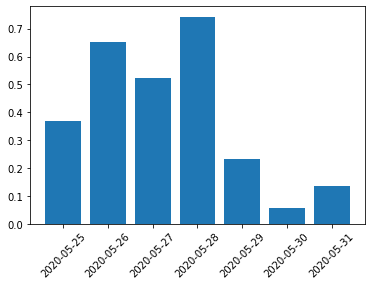

In [ ]:
#visualise cumulative p-value
dates=data1['date'].sort_values(ascending=True).unique()
plt.bar(dates, ttest)
plt.xticks(rotation=45)
plt.show()

**Result:** you shouldn't add cats, even though the p-value indicates that the results of the stat are significant (some days), the difference in conversions between the test and control groups is either positive or negative